In [ ]:
!pip install psycopg2 pandas matplotlib


In [ ]:
# import psycopg2
# import pandas as pd

# # Database connection parameters
# host = "150.230.166.174"
# port = 5432
# database = "dkist"
# user = "dkist"
# password = "sdbsdb!"

# # Connect to the PostgreSQL database
# conn = psycopg2.connect(
#     host=host,
#     port=port,
#     database=database,
#     user=user,
#     password=password
# )

# # Query to fetch rapid growth results
# query = """
# WITH combined_granules AS (
#     -- Combine all four tables into a single dataset
#     SELECT
#         'granule_with_dot' AS source_table,
#         id,
#         tracked_id,
#         time,
#         shape
#     FROM granule_with_dot
#     UNION ALL
#     SELECT
#         'granule_with_lane' AS source_table,
#         id,
#         tracked_id,
#         time,
#         shape
#     FROM granule_with_lane
#     UNION ALL
#     SELECT
#         'complex_granule' AS source_table,
#         id,
#         tracked_id,
#         time,
#         shape
#     FROM complex_granule
#     UNION ALL
#     SELECT
#         'uniform_granule' AS source_table,
#         id,
#         tracked_id,
#         time,
#         shape
#     FROM uniform_granule
# ),

# sorted_granules AS (
#     -- Sort data by tracked_id and time
#     SELECT
#         source_table,
#         id,
#         tracked_id,
#         time,
#         ST_Area(shape) AS area, -- Calculate the area
#         ROW_NUMBER() OVER (PARTITION BY tracked_id ORDER BY time) AS row_num
#     FROM
#         combined_granules
# ),

# ten_frames AS (
#     -- Divide data into 10 approximately equal frames
#     SELECT
#         *,
#         NTILE(10) OVER (PARTITION BY tracked_id ORDER BY time) AS frame_number
#     FROM
#         sorted_granules
# ),

# growth_tracking AS (
#     -- Track initial and final areas for each granule across frames
#     SELECT
#         tracked_id,
#         MIN(CASE WHEN frame_number = 1 THEN area ELSE NULL END) AS initial_area,
#         MAX(CASE WHEN frame_number = 10 THEN area ELSE NULL END) AS final_area,
#         MIN(CASE WHEN frame_number = 1 THEN source_table ELSE NULL END) AS initial_source_table
#     FROM
#         ten_frames
#     GROUP BY
#         tracked_id
# ),

# growth_calculation AS (
#     -- Calculate the growth based on initial and final areas
#     SELECT
#         tracked_id,
#         initial_source_table,
#         initial_area,
#         final_area,
#         ((final_area - initial_area) / initial_area) AS size_increase
#     FROM
#         growth_tracking
#     WHERE
#         initial_area IS NOT NULL AND final_area IS NOT NULL -- Ensure valid data
# )

# -- Final Step: Identify granules with significant growth
# SELECT
#     tracked_id,
#     initial_source_table,
#     initial_area,
#     final_area,
#     size_increase
# FROM
#     growth_calculation
# WHERE
#     size_increase >= 0.9 -- Threshold for rapid growth
# ORDER BY
#     size_increase DESC;

# """

# # Execute the query
# df = pd.read_sql_query(query, conn)

# # Close the connection
# conn.close()

# # Display the first few rows of the result
# print(df.shape)


In [ ]:
print(df.columns)

Index(['tracked_id', 'initial_source_table', 'initial_area', 'final_area',
       'size_increase'],
      dtype='object')


In [ ]:
# import matplotlib.pyplot as plt

# # Plot histogram of size increases
# plt.figure(figsize=(10, 6))
# plt.hist(df['size_increase'], bins=20, color='skyblue', edgecolor='black')
# plt.title('Size Increase Distribution of Rapidly Growing Granules')
# plt.xlabel('Size Increase')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()


In [ ]:
# # Plot growth over time for each tracked_id
# plt.figure(figsize=(12, 8))
# for tracked_id in df['tracked_id'].unique():
#     subset = df[df['tracked_id'] == tracked_id]
#     plt.plot(subset['initial_time'], subset['initial_area'], label=f'Tracked ID: {tracked_id}')

# plt.title('Growth Over Time for Rapidly Growing Granules')
# plt.xlabel('Time')
# plt.ylabel('Area')
# plt.legend()
# plt.grid(True)
# plt.show()


**WORKING**

In [ ]:
import psycopg2
import pandas as pd

# Database connection parameters
host = "150.230.166.174"
port = 5432
database = "dkist"
user = "dkist"
password = "sdbsdb!"

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host=host,
    port=port,
    database=database,
    user=user,
    password=password
)

# Query to fetch rapid growth results
query = """
WITH combined_granules AS (
    -- Combine all four tables into a single dataset
    SELECT
        'granule_with_dot' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM granule_with_dot
    UNION ALL
    SELECT
        'granule_with_lane' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM granule_with_lane
    UNION ALL
    SELECT
        'complex_granule' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM complex_granule
    UNION ALL
    SELECT
        'uniform_granule' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM uniform_granule
)
select * from combined_granules where tracked_id=174 order by time;
"""

# Execute the query
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Display the first few rows of the result
print(df.shape)


<ipython-input-2-27be8ec73d2e>:60: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


(12, 5)


In [ ]:
from shapely.wkb import loads as wkb_loads

# Convert shape column to areas
df['area'] = df['shape'].apply(lambda geom: wkb_loads(geom, hex=True).area)

# Ensure time is sorted for proper percentage growth calculation
df = df.sort_values(by="time")

# Calculate the percentage increase relative to the first area
initial_area = df['area'].iloc[0]
df['percent_growth'] = ((df['area'] - initial_area) / initial_area) * 100


In [ ]:
# import plotly.express as px

# # Ensure time is in datetime format
# df['time'] = pd.to_datetime(df['time'])

# # Plot area growth over time
# fig = px.line(
#     df,
#     x='time',
#     y='area',
#     title='Granule Area Growth Over Time',
#     labels={'time': 'Time', 'area': 'Area'},
#     template='plotly_dark'
# )
# fig.show()


In [ ]:
import plotly.express as px

# Ensure time is sorted for proper percentage growth calculation
df = df.sort_values(by="time")

# Calculate the percentage growth relative to the first area
initial_area = df['area'].iloc[0]
df['percent_growth'] = ((df['area'] - initial_area) / initial_area) * 100

# Create a line plot
fig = px.line(
    df,
    x='time',
    y='area',
    color='source_table',  # Use source_table as a categorical color
    title='Granule Area Growth Over Time (tracked_id:174)',
    labels={
        'time': 'Time',
        'area': 'Granule Area',
        'source_table': 'Source Table',
    },
    template='plotly_dark',
    hover_data={
        'source_table': True,         # Include source table
        'percent_growth': ':.2f%'    # Format percentage growth
    }
)

# Customize hover template to show data properly
fig.update_traces(
    mode='lines+markers',
    hovertemplate="<b>Time:</b> %{x}<br>"
                  "<b>Area:</b> %{y:.2f}<br>"
                  "<b>Source Table:</b> %{customdata[0]}<br>"
                  "<b>Growth:</b> %{customdata[1]:.2f}%"  # Use growth data
)

# Show the plot
fig.show()


In [ ]:
 !pip install -U kaleido

In [ ]:
#fig.write_image("id174.png")
fig.write_html("plotly_174.html")


In [ ]:
   from google.colab import drive
   drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
  from google.colab import files
files.download('/content/plotly_174.html')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# # Replace 'specific_tracked_id' with the actual ID you want to filter
# specific_tracked_id = 20

# # Filter the DataFrame for the specific tracked_id
# filtered_df = df[df['tracked_id'] == specific_tracked_id]

# # Check if the filtered DataFrame is not empty
# if filtered_df.empty:
#     print(f"No data found for tracked_id: {specific_tracked_id}")
# else:
#     # Create the scatter plot for the filtered data
#     fig = px.scatter(
#         filtered_df,
#         x="initial_time",
#         y="size_increase",
#         color="initial_source_table",
#         hover_data=["initial_area", "final_area"],
#         title=f"Rapid Growth for Tracked ID: {specific_tracked_id}",
#         labels={"initial_time": "Initial Time", "size_increase": "Size Increase"}
#     )
#     fig.show()


In [ ]:
import psycopg2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkb

# Database connection parameters
host = "150.230.166.174"
port = 5432
database = "dkist"
user = "dkist"
password = "sdbsdb!"

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host=host,
    port=port,
    database=database,
    user=user,
    password=password
)

# SQL query to fetch granules for a specific tracked_id and their growth over frames
tracked_id_of_interest = 174  # Specify the tracked_id you want to visualize (change as needed)

query = f"""
WITH combined_granules AS (
    -- Combine all four tables into a single dataset
    SELECT
        'granule_with_dot' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM granule_with_dot
    UNION ALL
    SELECT
        'granule_with_lane' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM granule_with_lane
    UNION ALL
    SELECT
        'complex_granule' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM complex_granule
    UNION ALL
    SELECT
        'uniform_granule' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM uniform_granule
)
select * from combined_granules where tracked_id=174 order by time;

"""

# Fetch the data from the database
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Convert the WKB geometry in the 'shape' column to shapely geometry
def parse_wkb(hex_string):
    try:
        return wkb.loads(bytes.fromhex(hex_string))
    except Exception as e:
        print(f"Error parsing WKB: {e}")
        return None

# Apply the function to convert hex WKB to geometry
df['geometry'] = df['shape'].apply(parse_wkb)

# Drop any rows where geometry parsing failed
df = df.dropna(subset=['geometry'])

# Convert the DataFrame to GeoDataFrame for geospatial operations
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Assign a row_number column for plotting frames (assume it is already calculated)
if 'row_number' not in gdf.columns:
    gdf['row_number'] = gdf.groupby('tracked_id').cumcount() + 1

# Iterate through the 10 frames and save each frame as a separate image
for i in range(10):
    # Filter the granule for the i-th frame (adjust based on row_number)
    granule_at_frame = gdf[gdf['row_number'] == i + 1]

    # Create a new figure for each frame
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot all granules in light blue (background)
    gdf.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5)

    # Highlight the specific granule at this frame in red
    granule_at_frame.plot(ax=ax, color='red', edgecolor='black', alpha=1.0)

    # Add a title for the frame
    ax.set_title(f"Frame {i+1}", fontsize=12)

    # Save the plot as a separate image
    plt.savefig(f"frame_{i+1}.png", dpi=300)
    plt.close(fig)

print("Images have been saved as 'frame_1.png' to 'frame_10.png'.")


<ipython-input-18-fb33e9970127>:66: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



Images have been saved as 'frame_1.png' to 'frame_10.png'.


<ipython-input-1-4d813ba76125>:66: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


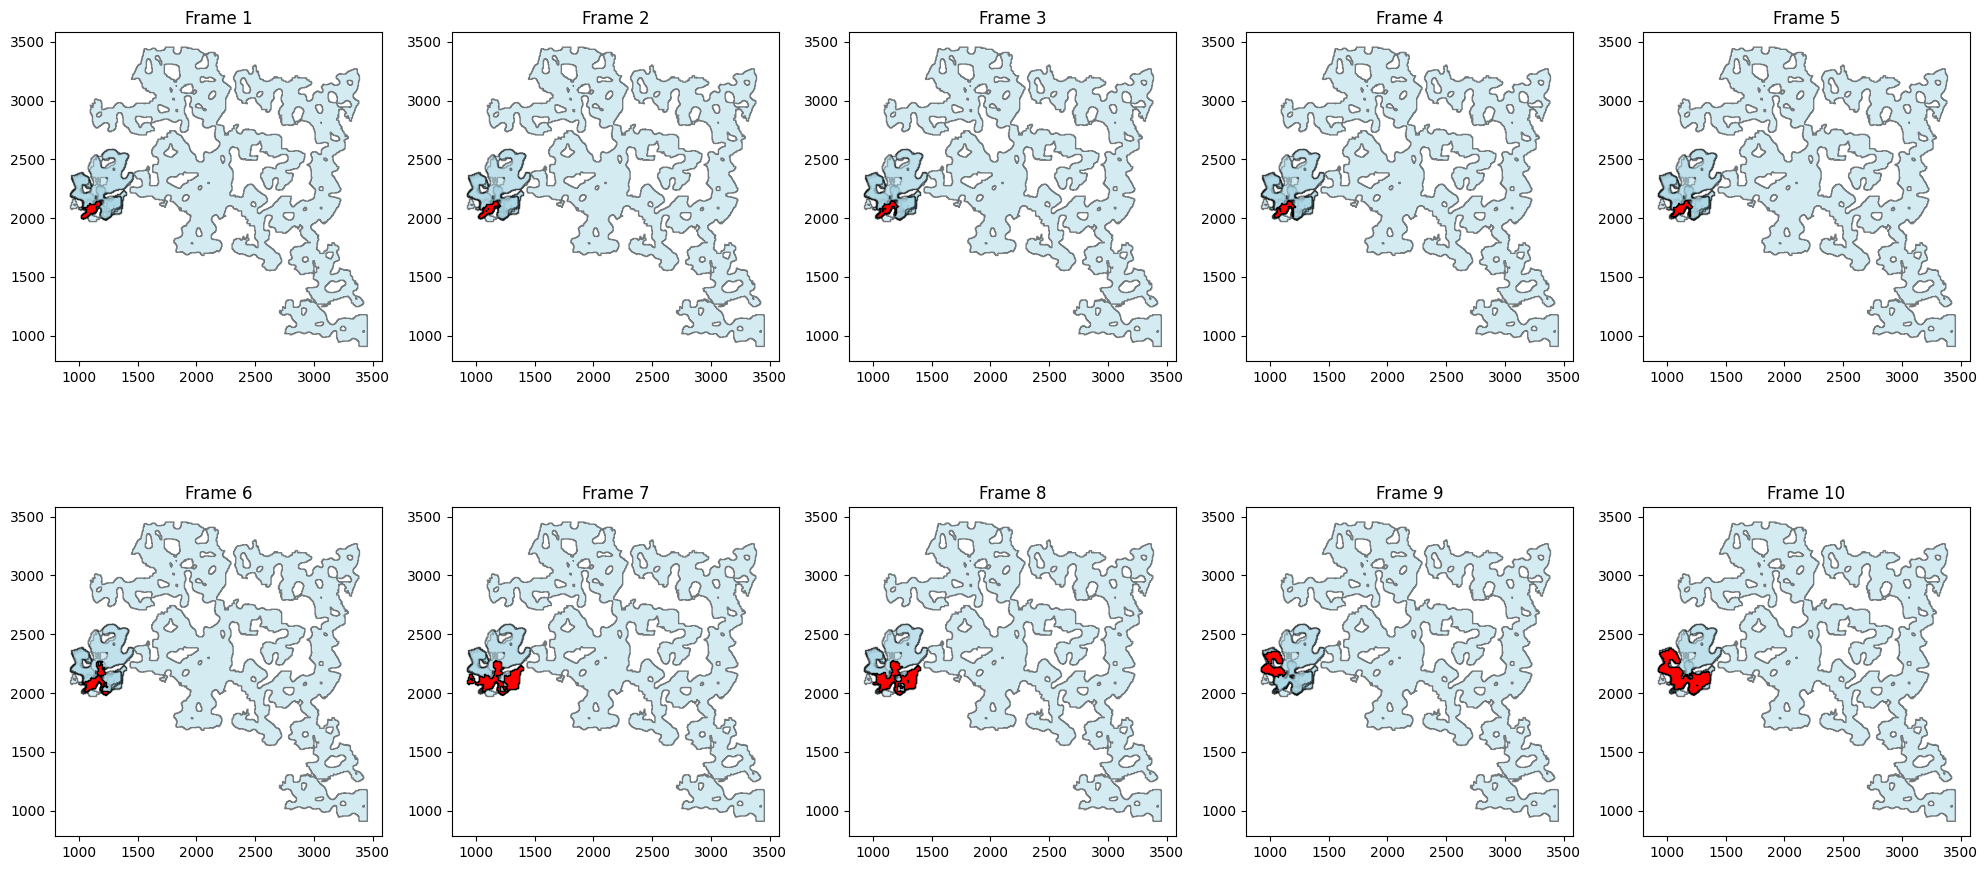

In [ ]:
import psycopg2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkb

# Database connection parameters
host = "150.230.166.174"
port = 5432
database = "dkist"
user = "dkist"
password = "sdbsdb!"

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host=host,
    port=port,
    database=database,
    user=user,
    password=password
)

# SQL query to fetch granules for a specific tracked_id and their growth over frames
tracked_id_of_interest = 123  # Specify the tracked_id you want to visualize (change as needed)

query = f"""
WITH combined_granules AS (
    -- Combine all four tables into a single dataset
    SELECT
        'granule_with_dot' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM granule_with_dot
    UNION ALL
    SELECT
        'granule_with_lane' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM granule_with_lane
    UNION ALL
    SELECT
        'complex_granule' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM complex_granule
    UNION ALL
    SELECT
        'uniform_granule' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM uniform_granule
)
select * from combined_granules where tracked_id=174 order by time;

"""

# Fetch the data from the database
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Convert the WKB geometry in the 'shape' column to shapely geometry
def parse_wkb(hex_string):
    try:
        return wkb.loads(bytes.fromhex(hex_string))
    except Exception as e:
        print(f"Error parsing WKB: {e}")
        return None

# Apply the function to convert hex WKB to geometry
df['geometry'] = df['shape'].apply(parse_wkb)

# Drop any rows where geometry parsing failed
df = df.dropna(subset=['geometry'])

# Convert the DataFrame to GeoDataFrame for geospatial operations
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Assign a row_number column for plotting frames (assume it is already calculated)
# If `row_number` doesn't exist, you need logic to group and enumerate rows.
# Example:
if 'row_number' not in gdf.columns:
    gdf['row_number'] = gdf.groupby('tracked_id').cumcount() + 1

# Plotting setup: 2x5 grid for 10 frames
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
ax = ax.flatten()

# Iterate through the 10 frames and plot
for i in range(10):
    # Filter the granule for the i-th frame (adjust based on row_number)
    granule_at_frame = gdf[gdf['row_number'] == i + 1]  # Adjust row_num for correct indexing

    # Plot all granules in light blue (background)
    gdf.plot(ax=ax[i], color='lightblue', edgecolor='black', alpha=0.5)

    # Highlight the specific granule at this frame in red
    granule_at_frame.plot(ax=ax[i], color='red', edgecolor='black', alpha=1.0)

    # Add a title for each frame
    ax[i].set_title(f"Frame {i+1}", fontsize=12)

# Adjust layout for better visibility
plt.tight_layout()
plt.savefig("rapidgrowth.pdf")
plt.show()


<ipython-input-2-78a01caffaeb>:66: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


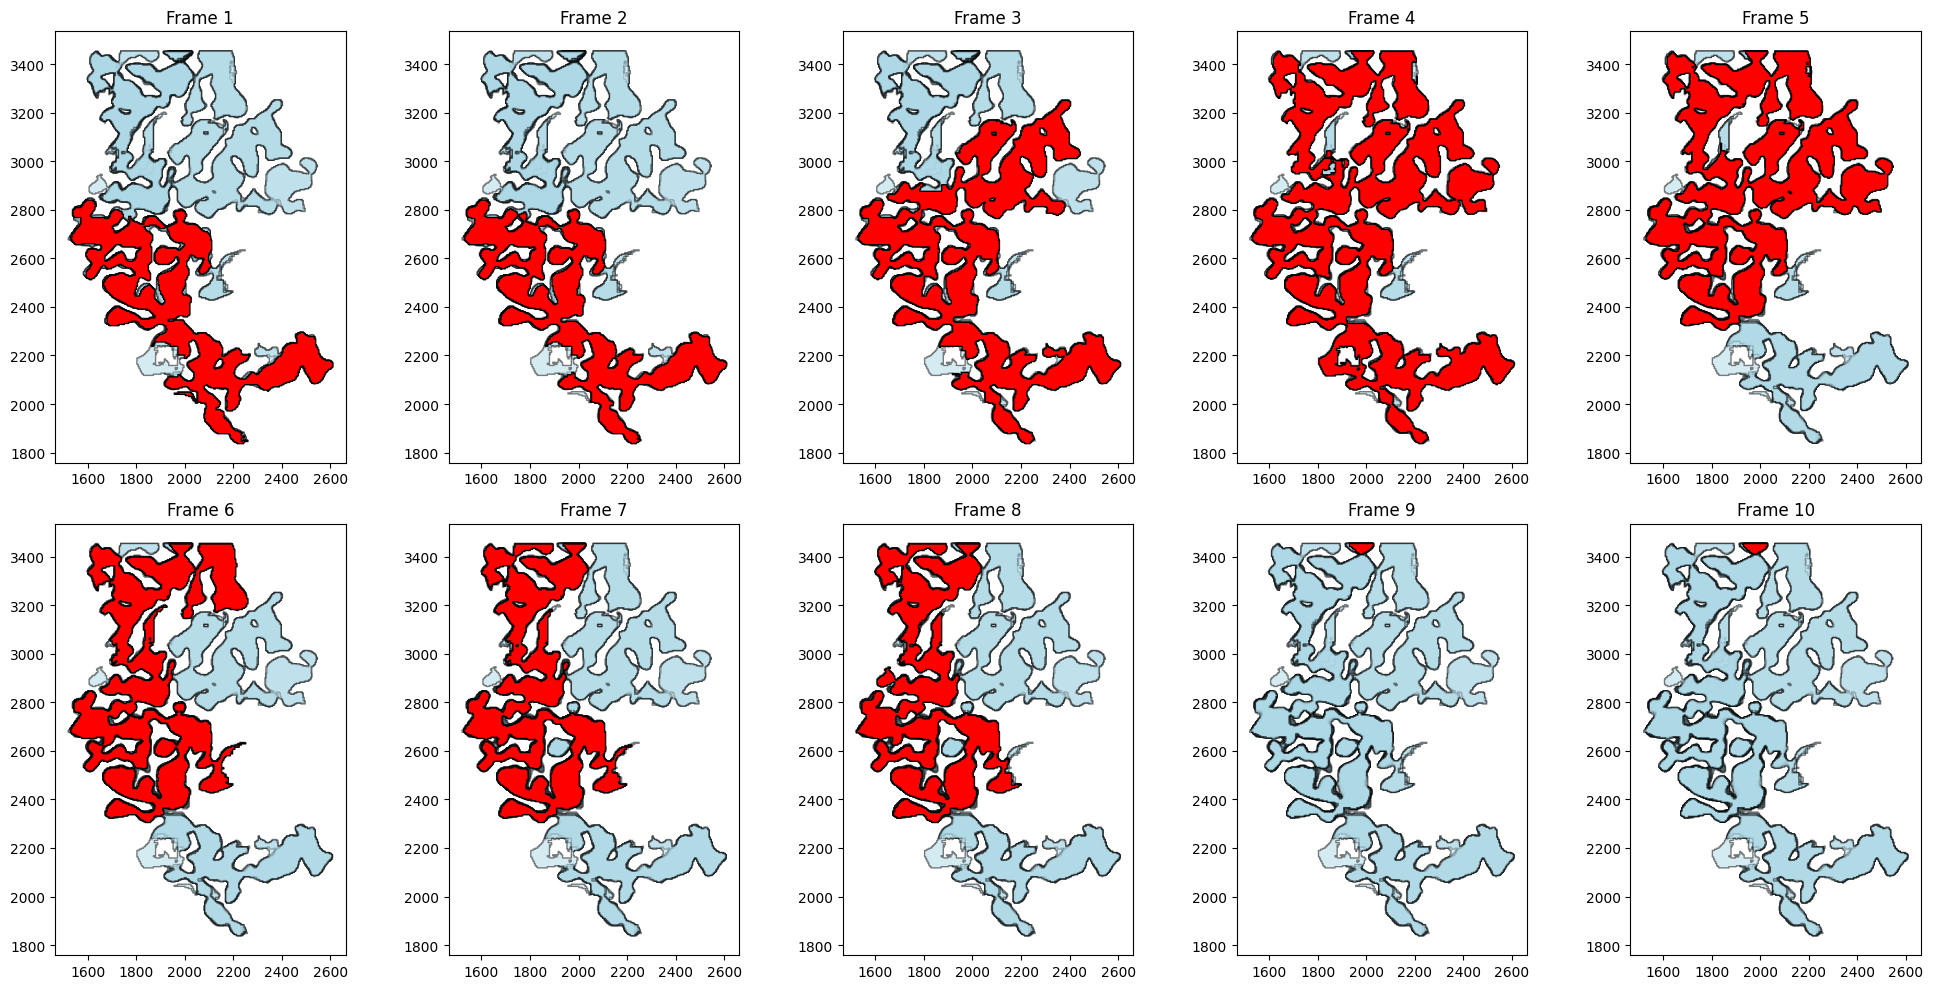

In [ ]:
import psycopg2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkb

# Database connection parameters
host = "150.230.166.174"
port = 5432
database = "dkist"
user = "dkist"
password = "sdbsdb!"

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host=host,
    port=port,
    database=database,
    user=user,
    password=password
)

# SQL query to fetch granules for a specific tracked_id and their growth over frames
tracked_id_of_interest =6455  # Specify the tracked_id you want to visualize (change as needed)

query = f"""
WITH combined_granules AS (
    -- Combine all four tables into a single dataset
    SELECT
        'granule_with_dot' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM granule_with_dot
    UNION ALL
    SELECT
        'granule_with_lane' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM granule_with_lane
    UNION ALL
    SELECT
        'complex_granule' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM complex_granule
    UNION ALL
    SELECT
        'uniform_granule' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM uniform_granule
)
select * from combined_granules where tracked_id=6455 order by time;

"""

# Fetch the data from the database
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Convert the WKB geometry in the 'shape' column to shapely geometry
def parse_wkb(hex_string):
    try:
        return wkb.loads(bytes.fromhex(hex_string))
    except Exception as e:
        print(f"Error parsing WKB: {e}")
        return None

# Apply the function to convert hex WKB to geometry
df['geometry'] = df['shape'].apply(parse_wkb)

# Drop any rows where geometry parsing failed
df = df.dropna(subset=['geometry'])

# Convert the DataFrame to GeoDataFrame for geospatial operations
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Assign a row_number column for plotting frames (assume it is already calculated)
# If `row_number` doesn't exist, you need logic to group and enumerate rows.
# Example:
if 'row_number' not in gdf.columns:
    gdf['row_number'] = gdf.groupby('tracked_id').cumcount() + 1

# Plotting setup: 2x5 grid for 10 frames
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
ax = ax.flatten()

# Iterate through the 10 frames and plot
for i in range(10):
    # Filter the granule for the i-th frame (adjust based on row_number)
    granule_at_frame = gdf[gdf['row_number'] == i + 1]  # Adjust row_num for correct indexing

    # Plot all granules in light blue (background)
    gdf.plot(ax=ax[i], color='lightblue', edgecolor='black', alpha=0.5)

    # Highlight the specific granule at this frame in red
    granule_at_frame.plot(ax=ax[i], color='red', edgecolor='black', alpha=1.0)

    # Add a title for each frame
    ax[i].set_title(f"Frame {i+1}", fontsize=12)

# Adjust layout for better visibility
plt.tight_layout()
plt.savefig("rapidDecreasegrowth.pdf")
plt.show()


In [ ]:
import psycopg2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkb

# Database connection parameters
host = "150.230.166.174"
port = 5432
database = "dkist"
user = "dkist"
password = "sdbsdb!"

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host=host,
    port=port,
    database=database,
    user=user,
    password=password
)

# SQL query to fetch granules for a specific tracked_id and their growth over frames
tracked_id_of_interest = 6455  # Specify the tracked_id you want to visualize (change as needed)

query = f"""
WITH combined_granules AS (
    -- Combine all four tables into a single dataset
    SELECT
        'granule_with_dot' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM granule_with_dot
    UNION ALL
    SELECT
        'granule_with_lane' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM granule_with_lane
    UNION ALL
    SELECT
        'complex_granule' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM complex_granule
    UNION ALL
    SELECT
        'uniform_granule' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM uniform_granule
)
SELECT * FROM combined_granules WHERE tracked_id = {tracked_id_of_interest} ORDER BY time;
"""

# Fetch the data from the database
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Convert the WKB geometry in the 'shape' column to shapely geometry
def parse_wkb(hex_string):
    try:
        return wkb.loads(bytes.fromhex(hex_string))
    except Exception as e:
        print(f"Error parsing WKB: {e}")
        return None

# Apply the function to convert hex WKB to geometry
df['geometry'] = df['shape'].apply(parse_wkb)

# Drop any rows where geometry parsing failed
df = df.dropna(subset=['geometry'])

# Convert the DataFrame to GeoDataFrame for geospatial operations
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Assign a row_number column for plotting frames (assume it is already calculated)
# If `row_number` doesn't exist, you need logic to group and enumerate rows.
if 'row_number' not in gdf.columns:
    gdf['row_number'] = gdf.groupby('tracked_id').cumcount() + 1

# Generate individual plots for each frame
for i in range(10):
    # Filter the granule for the i-th frame (adjust based on row_number)
    granule_at_frame = gdf[gdf['row_number'] == i + 1]  # Adjust row_num for correct indexing

    # Create a new figure for each frame
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot all granules in light blue (background)
    gdf.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5)

    # Highlight the specific granule at this frame in red
    granule_at_frame.plot(ax=ax, color='red', edgecolor='black', alpha=1.0)

    # Add a title for the frame
    ax.set_title(f"Frame {i+1}", fontsize=14)

    # Save the plot as a separate image
    plt.savefig(f"frame_{i+1}.png", dpi=300)

    # Close the plot to avoid overlapping
    plt.close(fig)

print("Individual frame images saved successfully.")


<ipython-input-23-0385514da648>:65: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



Individual frame images saved successfully.


In [ ]:
import psycopg2
import pandas as pd
import geopandas as gpd
from shapely import wkb
import plotly.express as px

# Database connection parameters
host = "150.230.166.174"
port = 5432
database = "dkist"
user = "dkist"
password = "sdbsdb!"

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host=host,
    port=port,
    database=database,
    user=user,
    password=password
)

# SQL query to fetch granules for a specific tracked_id and their growth over frames
tracked_id_of_interest = 6455  # Specify the tracked_id you want to visualize (change as needed)

query = f"""
WITH combined_granules AS (
    -- Combine all four tables into a single dataset
    SELECT
        'granule_with_dot' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM granule_with_dot
    UNION ALL
    SELECT
        'granule_with_lane' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM granule_with_lane
    UNION ALL
    SELECT
        'complex_granule' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM complex_granule
    UNION ALL
    SELECT
        'uniform_granule' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM uniform_granule
)
SELECT * FROM combined_granules WHERE tracked_id = 6455 ORDER BY time;
"""

# Fetch the data from the database
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Convert the WKB geometry in the 'shape' column to shapely geometry
def parse_wkb(hex_string):
    try:
        return wkb.loads(bytes.fromhex(hex_string))
    except Exception as e:
        print(f"Error parsing WKB: {e}")
        return None

# Apply the function to convert hex WKB to geometry
df['geometry'] = df['shape'].apply(parse_wkb)

# Drop any rows where geometry parsing failed
df = df.dropna(subset=['geometry'])

# Calculate the area of each granule
df['area'] = df['geometry'].apply(lambda geom: geom.area if geom else 0)

# Ensure time is sorted for proper percentage growth calculation
df = df.sort_values(by="time")

# Calculate the percentage growth relative to the first area
initial_area = df['area'].iloc[0]
df['percent_growth'] = ((df['area'] - initial_area) / initial_area) * 100

# Create a Plotly line plot
fig = px.line(
    df,
    x='time',
    y='area',
    color='source_table',  # Use source_table as a categorical color
    title=f'Granule Area Growth Over Time (tracked_id:{tracked_id_of_interest})',
    labels={
        'time': 'Time',
        'area': 'Granule Area',
        'source_table': 'Source Table',
    },
    template='plotly_dark',
    hover_data={
        'source_table': True,         # Include source table
        'percent_growth': ':.2f%'    # Format percentage growth
    }
)

# Customize hover template
fig.update_traces(
    mode='lines+markers',
    hovertemplate="<b>Time:</b> %{x}<br>"
                  "<b>Area:</b> %{y:.2f}<br>"
                  "<b>Source Table:</b> %{customdata[0]}<br>"
                  "<b>Growth:</b> %{customdata[1]:.2f}%"  # Use growth data
)

# Show the plot
fig.show()


<ipython-input-1-a0be720ade21>:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [ ]:
fig.write_html("plotly_6455.html")

<ipython-input-22-a61b654d02f1>:66: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



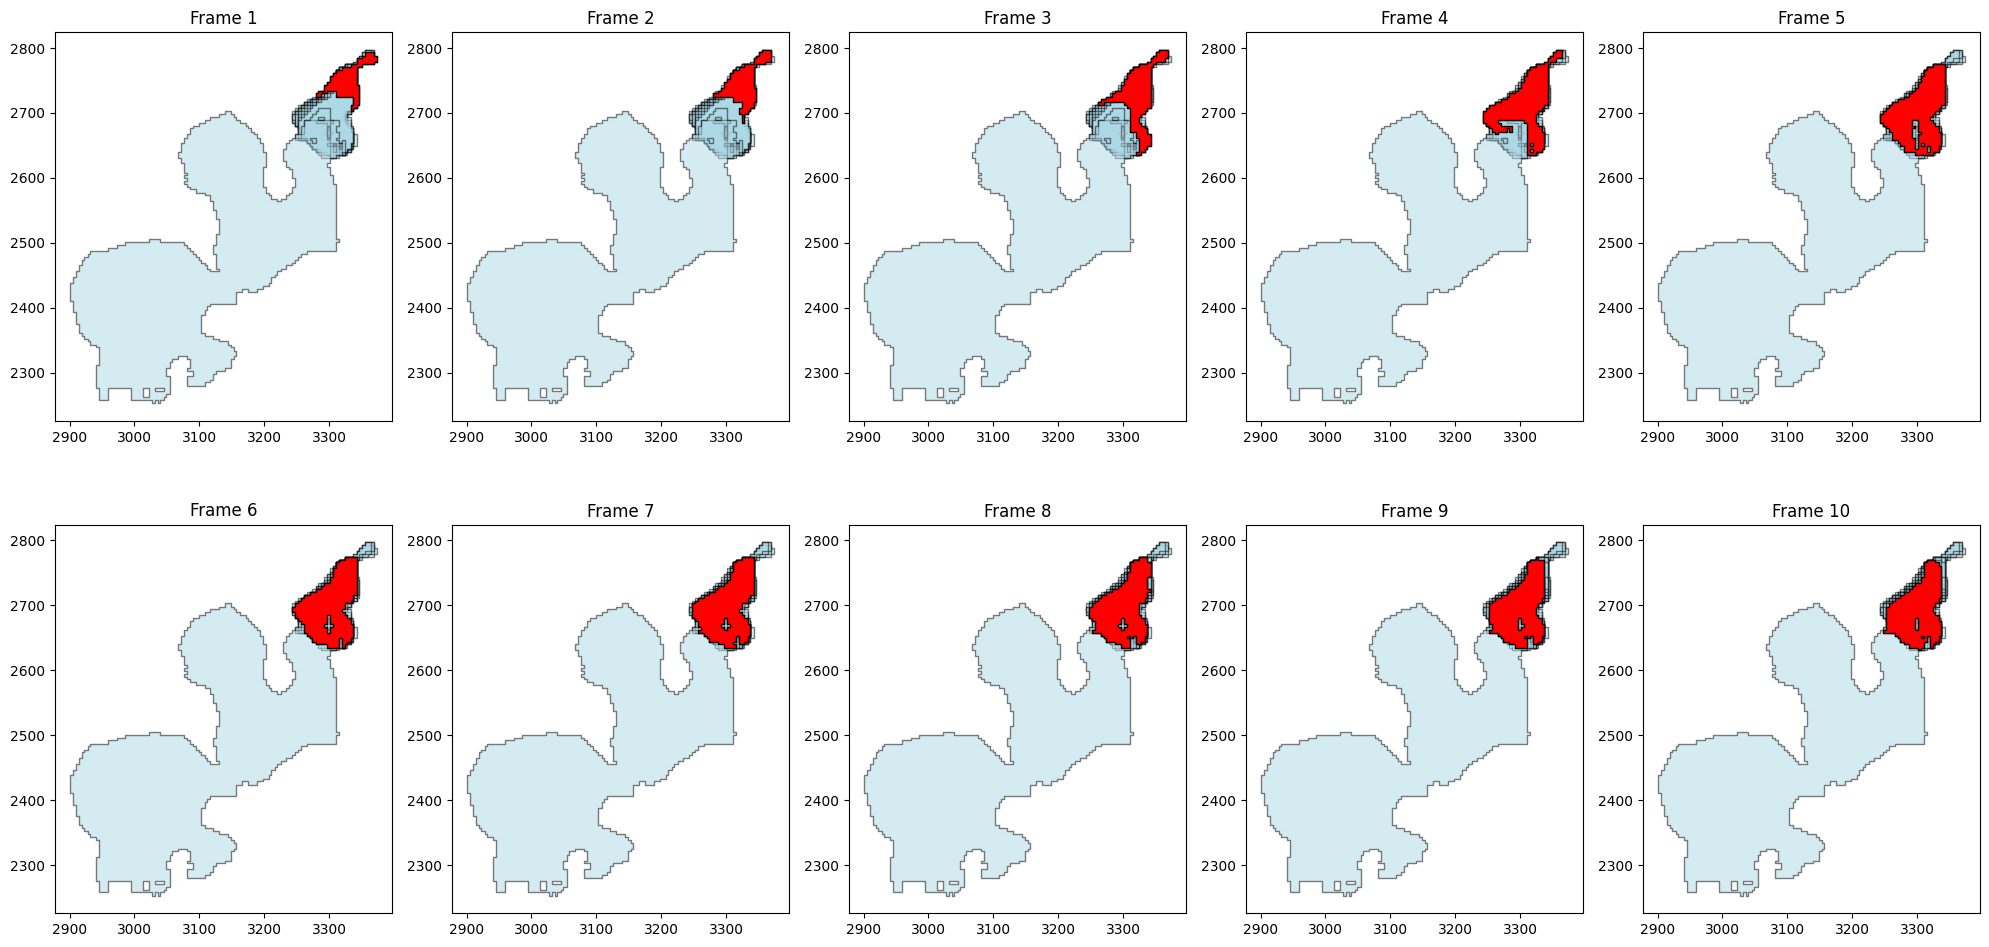

In [ ]:
import psycopg2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkb

# Database connection parameters
host = "150.230.166.174"
port = 5432
database = "dkist"
user = "dkist"
password = "sdbsdb!"

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host=host,
    port=port,
    database=database,
    user=user,
    password=password
)

# SQL query to fetch granules for a specific tracked_id and their growth over frames
tracked_id_of_interest = 123  # Specify the tracked_id you want to visualize (change as needed)

query = f"""
WITH combined_granules AS (
    -- Combine all four tables into a single dataset
    SELECT
        'granule_with_dot' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM granule_with_dot
    UNION ALL
    SELECT
        'granule_with_lane' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM granule_with_lane
    UNION ALL
    SELECT
        'complex_granule' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM complex_granule
    UNION ALL
    SELECT
        'uniform_granule' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM uniform_granule
)
select * from combined_granules where tracked_id= order by time;

"""

# Fetch the data from the database
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Convert the WKB geometry in the 'shape' column to shapely geometry
def parse_wkb(hex_string):
    try:
        return wkb.loads(bytes.fromhex(hex_string))
    except Exception as e:
        print(f"Error parsing WKB: {e}")
        return None

# Apply the function to convert hex WKB to geometry
df['geometry'] = df['shape'].apply(parse_wkb)

# Drop any rows where geometry parsing failed
df = df.dropna(subset=['geometry'])

# Convert the DataFrame to GeoDataFrame for geospatial operations
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Assign a row_number column for plotting frames (assume it is already calculated)
# If `row_number` doesn't exist, you need logic to group and enumerate rows.
# Example:
if 'row_number' not in gdf.columns:
    gdf['row_number'] = gdf.groupby('tracked_id').cumcount() + 1

# Plotting setup: 2x5 grid for 10 frames
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
ax = ax.flatten()

# Iterate through the 10 frames and plot
for i in range(10):
    # Filter the granule for the i-th frame (adjust based on row_number)
    granule_at_frame = gdf[gdf['row_number'] == i + 1]  # Adjust row_num for correct indexing

    # Plot all granules in light blue (background)
    gdf.plot(ax=ax[i], color='lightblue', edgecolor='black', alpha=0.5)

    # Highlight the specific granule at this frame in red
    granule_at_frame.plot(ax=ax[i], color='red', edgecolor='black', alpha=1.0)

    # Add a title for each frame
    ax[i].set_title(f"Frame {i+1}", fontsize=12)

# Adjust layout for better visibility
plt.tight_layout()
plt.show()


In [ ]:
from shapely.wkb import loads as wkb_loads

# Convert shape column to areas
df['area'] = df['shape'].apply(lambda geom: wkb_loads(geom, hex=True).area)

# Ensure time is sorted for proper percentage growth calculation
df = df.sort_values(by="time")

# Calculate the percentage increase relative to the first area
initial_area = df['area'].iloc[0]
df['percent_growth'] = ((df['area'] - initial_area) / initial_area) * 100


In [ ]:
import plotly.express as px

# Ensure time is sorted for proper percentage growth calculation
df = df.sort_values(by="time")

# Calculate the percentage growth relative to the first area
initial_area = df['area'].iloc[0]
df['percent_growth'] = ((df['area'] - initial_area) / initial_area) * 100

# Create a line plot
fig = px.line(
    df,
    x='time',
    y='area',
    color='source_table',  # Use source_table as a categorical color
    title='Granule Area Growth Over Time (tracked_id:3142)',
    labels={
        'time': 'Time',
        'area': 'Granule Area',
        'source_table': 'Source Table',
    },
    template='plotly_dark',
    hover_data={
        'source_table': True,         # Include source table
        'percent_growth': ':.2f%'    # Format percentage growth
    }
)

# Customize hover template to show data properly
fig.update_traces(
    mode='lines+markers',
    hovertemplate="<b>Time:</b> %{x}<br>"
                  "<b>Area:</b> %{y:.2f}<br>"
                  "<b>Source Table:</b> %{customdata[0]}<br>"
                  "<b>Growth:</b> %{customdata[1]:.2f}%"  # Use growth data
)

# Show the plot
fig.show()


<ipython-input-10-2b69937b459e>:66: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



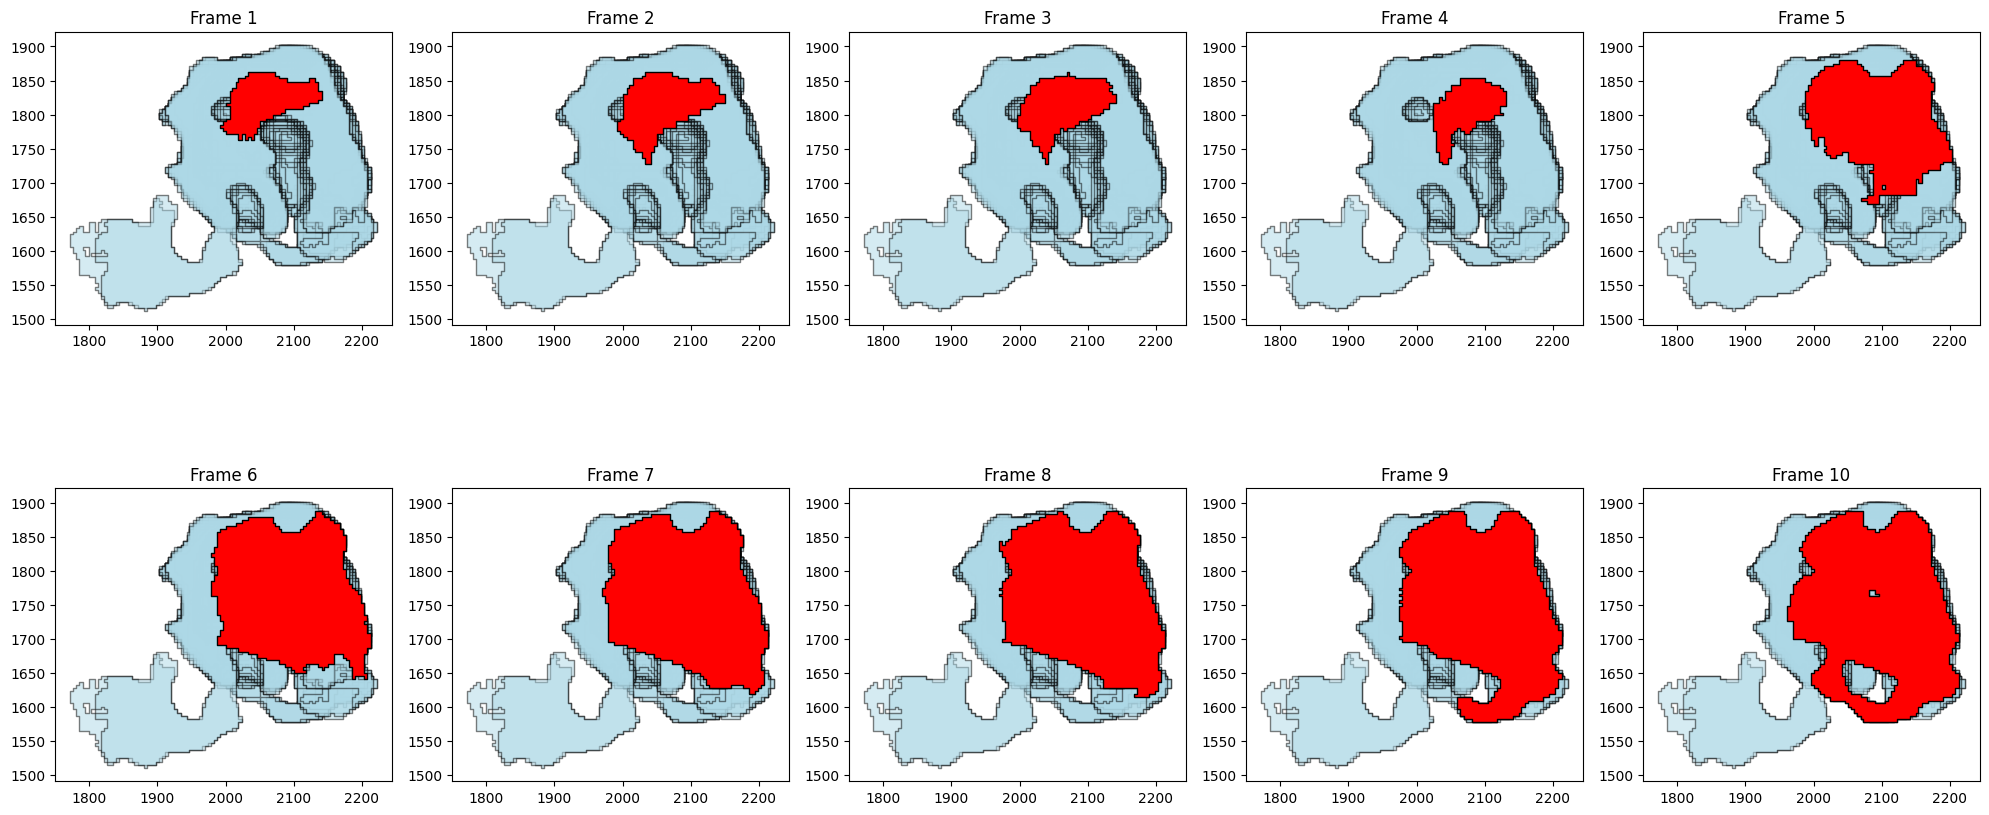

In [ ]:
import psycopg2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkb

# Database connection parameters
host = "150.230.166.174"
port = 5432
database = "dkist"
user = "dkist"
password = "sdbsdb!"

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host=host,
    port=port,
    database=database,
    user=user,
    password=password
)

# SQL query to fetch granules for a specific tracked_id and their growth over frames
tracked_id_of_interest = 123  # Specify the tracked_id you want to visualize (change as needed)

query = f"""
WITH combined_granules AS (
    -- Combine all four tables into a single dataset
    SELECT
        'granule_with_dot' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM granule_with_dot
    UNION ALL
    SELECT
        'granule_with_lane' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM granule_with_lane
    UNION ALL
    SELECT
        'complex_granule' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM complex_granule
    UNION ALL
    SELECT
        'uniform_granule' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM uniform_granule
)
select * from combined_granules where tracked_id=3397 order by time;

"""

# Fetch the data from the database
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Convert the WKB geometry in the 'shape' column to shapely geometry
def parse_wkb(hex_string):
    try:
        return wkb.loads(bytes.fromhex(hex_string))
    except Exception as e:
        print(f"Error parsing WKB: {e}")
        return None

# Apply the function to convert hex WKB to geometry
df['geometry'] = df['shape'].apply(parse_wkb)

# Drop any rows where geometry parsing failed
df = df.dropna(subset=['geometry'])

# Convert the DataFrame to GeoDataFrame for geospatial operations
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Assign a row_number column for plotting frames (assume it is already calculated)
# If `row_number` doesn't exist, you need logic to group and enumerate rows.
# Example:
if 'row_number' not in gdf.columns:
    gdf['row_number'] = gdf.groupby('tracked_id').cumcount() + 1

# Plotting setup: 2x5 grid for 10 frames
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
ax = ax.flatten()

# Iterate through the 10 frames and plot
for i in range(10):
    # Filter the granule for the i-th frame (adjust based on row_number)
    granule_at_frame = gdf[gdf['row_number'] == i + 1]  # Adjust row_num for correct indexing

    # Plot all granules in light blue (background)
    gdf.plot(ax=ax[i], color='lightblue', edgecolor='black', alpha=0.5)

    # Highlight the specific granule at this frame in red
    granule_at_frame.plot(ax=ax[i], color='red', edgecolor='black', alpha=1.0)

    # Add a title for each frame
    ax[i].set_title(f"Frame {i+1}", fontsize=12)

# Adjust layout for better visibility
plt.tight_layout()
plt.show()


In [ ]:
import psycopg2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkb

# Database connection parameters
host = "150.230.166.174"
port = 5432
database = "dkist"
user = "dkist"
password = "sdbsdb!"

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host=host,
    port=port,
    database=database,
    user=user,
    password=password
)

# SQL query to fetch granules for a specific tracked_id and their growth over frames
tracked_id_of_interest = 3124  # Specify the tracked_id you want to visualize

query = f"""
WITH combined_granules AS (
    -- Combine all four tables into a single dataset
    SELECT
        'granule_with_dot' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM granule_with_dot
    UNION ALL
    SELECT
        'granule_with_lane' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM granule_with_lane
    UNION ALL
    SELECT
        'complex_granule' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM complex_granule
    UNION ALL
    SELECT
        'uniform_granule' AS source_table,
        id,
        tracked_id,
        time,
        shape
    FROM uniform_granule
)
SELECT * FROM combined_granules WHERE tracked_id=3124 ORDER BY time;
"""

# Fetch the data from the database
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Convert the WKB geometry in the 'shape' column to shapely geometry
def parse_wkb(hex_string):
    try:
        return wkb.loads(bytes.fromhex(hex_string))
    except Exception as e:
        print(f"Error parsing WKB: {e}")
        return None

# Apply the function to convert hex WKB to geometry
df['geometry'] = df['shape'].apply(parse_wkb)

# Drop any rows where geometry parsing failed
df = df.dropna(subset=['geometry'])

# Convert the DataFrame to GeoDataFrame for geospatial operations
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Assign a row_number column for plotting frames (assume it is already calculated)
if 'row_number' not in gdf.columns:
    gdf['row_number'] = gdf.groupby('tracked_id').cumcount() + 1

# Iterate through the 10 frames and save each frame as a separate image
for i in range(10):
    # Filter the granule for the i-th frame (adjust based on row_number)
    granule_at_frame = gdf[gdf['row_number'] == i + 1]

    # Create a new figure for each frame
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot all granules in light blue (background)
    gdf.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5)

    # Highlight the specific granule at this frame in red
    granule_at_frame.plot(ax=ax, color='red', edgecolor='black', alpha=1.0)

    # Add a title for the frame
    ax.set_title(f"Tracked ID {tracked_id_of_interest} - Frame {i+1}", fontsize=12)

    # Save the plot as a separate image
    plt.savefig(f"tracked_{tracked_id_of_interest}_frame_{i+1}.png", dpi=300)
    plt.close(fig)

print("Images have been saved as 'tracked_3397_frame_1.png' to 'tracked_3397_frame_10.png'.")


<ipython-input-16-51a7d7a84d8e>:65: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

<ipython-input-16-51a7d7a84d8e>:103: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.

<ipython-input-16-51a7d7a84d8e>:103: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.

<ipython-input-16-51a7d7a84d8e>:103: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.

<ipython-input-16-51a7d7a84d8e>:103: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.

<ipython-input-16-51a7d7a84d8e>:103: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.

<ipython-input-16-51a7d7a84d8e>:103: UserWarning:

The GeoDataFrame you are attempting to p

Images have been saved as 'tracked_3397_frame_1.png' to 'tracked_3397_frame_10.png'.


In [ ]:
from shapely.wkb import loads as wkb_loads

# Convert shape column to areas
df['area'] = df['shape'].apply(lambda geom: wkb_loads(geom, hex=True).area)

# Ensure time is sorted for proper percentage growth calculation
df = df.sort_values(by="time")

# Calculate the percentage increase relative to the first area
initial_area = df['area'].iloc[0]
df['percent_growth'] = ((df['area'] - initial_area) / initial_area) * 100

In [ ]:
import plotly.express as px

# Ensure time is sorted for proper percentage growth calculation
df = df.sort_values(by="time")

# Calculate the percentage growth relative to the first area
initial_area = df['area'].iloc[0]
df['percent_growth'] = ((df['area'] - initial_area) / initial_area) * 100

# Create a line plot
fig = px.line(
    df,
    x='time',
    y='area',
    color='source_table',  # Use source_table as a categorical color
    title='Granule Area Growth Over Time (tracked_id:3142)',
    labels={
        'time': 'Time',
        'area': 'Granule Area',
        'source_table': 'Source Table',
    },
    template='plotly_dark',
    hover_data={
        'source_table': True,         # Include source table
        'percent_growth': ':.2f%'    # Format percentage growth
    }
)

# Customize hover template to show data properly
fig.update_traces(
    mode='lines+markers',
    hovertemplate="<b>Time:</b> %{x}<br>"
                  "<b>Area:</b> %{y:.2f}<br>"
                  "<b>Source Table:</b> %{customdata[0]}<br>"
                  "<b>Growth:</b> %{customdata[1]:.2f}%"  # Use growth data
)

# Show the plot
fig.show()
